In [2]:
# Package Imports
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

from shapely.geometry import MultiLineString, LineString, Polygon, Point
from shapely import wkt
from shapely.affinity import rotate, scale

import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show

import pulp

from spopt.locate.coverage import LSCP
from spopt.locate import PMedian

from importlib import reload

# to load the interactive plotting version
#matplotlib widget
# or regular
%matplotlib inline

# Importing my modules
import data_loading, set_cover, plotting, geometry_operations, optimization_functions, geometry_utilities

##### Reading the data and generate map

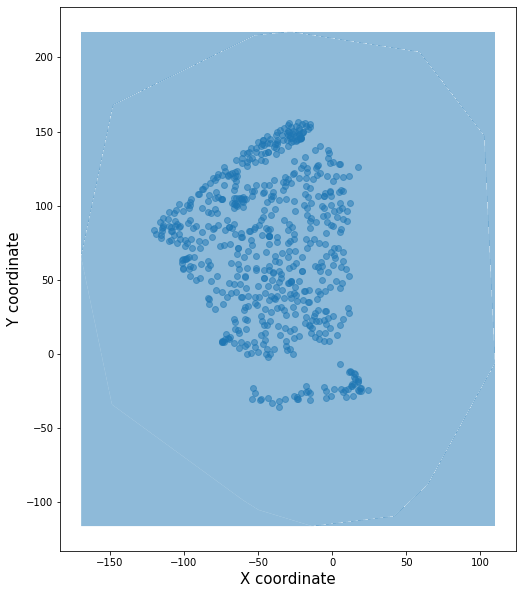

In [3]:
reload(data_loading)
# read TIF and CSV data
forest_area_gdf, bestand_3_csv, height_df = data_loading.load_bestand_and_forest()

# add trees to the map
point_list = [Point(xy) for xy in zip(bestand_3_csv["x"], bestand_3_csv["y"])]
tree_gdf = gpd.GeoDataFrame(data=bestand_3_csv,geometry=point_list)

# and add the geometry to the height_df
point_list = [Point(xy) for xy in zip(height_df["x"], height_df["y"])]
height_gdf = gpd.GeoDataFrame(data=height_df,geometry=point_list)

#verify that the boundary and trees add up
plotting.plot_gdfs([tree_gdf, forest_area_gdf])

#### Joining and Overlaying Anchor Areas and Road on the Map

##### Recording coordinates with interactive figure

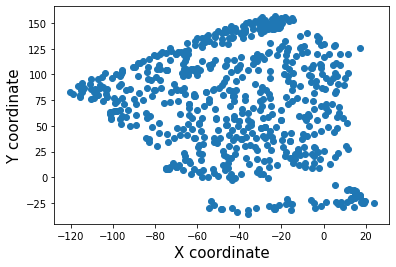

In [4]:
coords = []
fig, ax = plt.subplots()
ax.set_xlabel('X coordinate', fontsize=15)
ax.set_ylabel('Y coordinate', fontsize=15)
ax.scatter(tree_gdf["x"],tree_gdf["y"])

cid = fig.canvas.mpl_connect('button_press_event',  lambda event: plotting.onclick(event,coords))

In [5]:
# disconnect the interactive figure so it doesnt eat up resources
fig.canvas.mpl_disconnect(cid)

##### Creating extra_geometry_gpd from manual coordinates

/home/carlo/GitHub/MultiObjectOptimizationCableYarding/moo_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


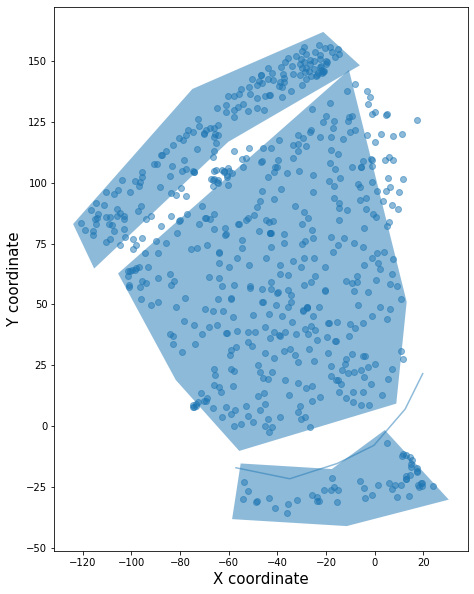

In [6]:
# manually insert those coordinates
# recorded coordinates for the given areas
downhill_anchors = Polygon([Point(xy) for xy in [(-123.88268627035482, 83.05479790035122), (-74.89307684787903, 138.5299549848453), (-21.10056454084676, 161.97821725767267), (-6.051468835903222, 148.2524051955298), (-60.16417466857257, 116.79741921978575), (-115.23746107815322, 64.75371515082742)]])
uphill_anchors = Polygon([Point(xy) for xy in [(-55.04107825837903, -15.31352187833928), (-17.578435758838708, -17.601157222029755), (4.194723984483858, -1.5877098161964227), (30.450593086725803, -30.18315161232738), (-11.49475877173387, -41.04941949485714), (-58.5632070403871, -38.189875315244045)]])
road = LineString([(-57.282432937838706, -17.029248386107135), (-34.86888614324194, -21.604519073488092), (-15.337081079379033, -15.31352187833928), (-0.2879853744354932, -7.878707011345227), (12.51975565104837, 6.990922722642864), (19.884206740701615, 21.86055245663097)])
inner_forest = Polygon([Point(xy) for xy in [(-105.43005197808363, 62.73802056488026), (-10.557896233758669, 146.34023494632802), (13.160142702322588, 51.07259530235265), (8.890895693827957, 9.27148811162877), (-55.62217021231302, -10.17088732591722), (-81.71201304200238, 18.992675830401765)]])

extra_geometry_gpd = gpd.GeoDataFrame(pd.DataFrame({"name":["uphill_anchors","road","downhill_anchors","inner_forest"],"geometry":[uphill_anchors,road,downhill_anchors,inner_forest]}))

# set the name as index to easily select the geometry
extra_geometry_gpd.set_index("name", inplace = True)
extra_geometry_gpd.loc['road']

plotting.plot_gdfs([tree_gdf,extra_geometry_gpd])

#### Generating Eligible Trees and Road Pathway

Getting the points along the road

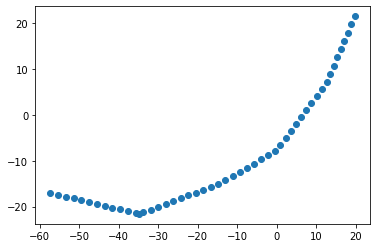

In [7]:
interval = 2
road_points = geometry_operations.generate_road_points(extra_geometry_gpd.loc['road'].geometry, interval)
plotting.plot_scatter_xy(road_points)

Getting the trees contained in the anchor/target tree polygons

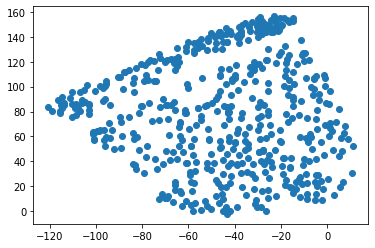

In [8]:
# get the eligible anchor and target trees inside the polygon
anchor_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["uphill_anchors"].geometry)
target_trees_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf,extra_geometry_gpd.loc["downhill_anchors"].geometry)
inner_forest_gdf = geometry_operations.filter_gdf_by_contained_elements(tree_gdf, extra_geometry_gpd.loc["inner_forest"].geometry)
harvesteable_trees_gdf = pd.concat([target_trees_gdf,inner_forest_gdf])

# and check if the anchor trees look good
plotting.plot_scatter_xy(harvesteable_trees_gdf.geometry)

#### Generating Possible Lines

##### Setting and rotating the slope line

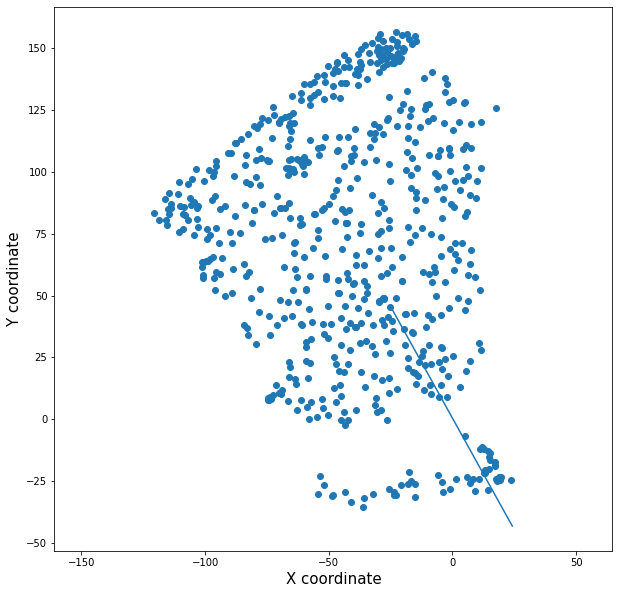

In [9]:
slope_degree = 29

# set a orientation line we can plan the line deviation around
slope_line = LineString([(0,0),(0,1)])
slope_line = rotate(slope_line, slope_degree)

# scale the line by a factor of 100 and plot it
slope_line = scale(slope_line,100,100)

ax = plotting.plot_equal_axis(slope_line)
ax.scatter(bestand_3_csv["x"], bestand_3_csv["y"])

##### Constraining lines to those with suitable anchor trees

<AxesSubplot:>

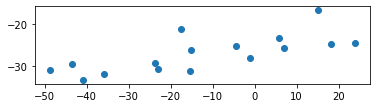

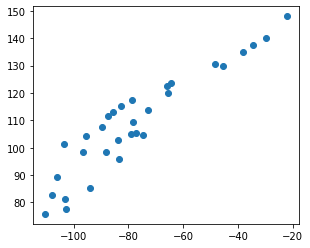

In [10]:
# Filter out uphill anchor trees with min_anchor_diameter < 40
min_anchor_diameter = 35
anchor_trees_gdf_filtered_diameter = anchor_trees_gdf[anchor_trees_gdf["BHD"]>min_anchor_diameter]
anchor_trees_gdf_filtered_diameter.plot()

# And filter the target trees
target_trees_gdf_filtered_diameter = target_trees_gdf[target_trees_gdf["BHD"]>min_anchor_diameter]
target_trees_gdf_filtered_diameter.plot()

##### Generating the possible lines depending on the slope

we have n lines:  64


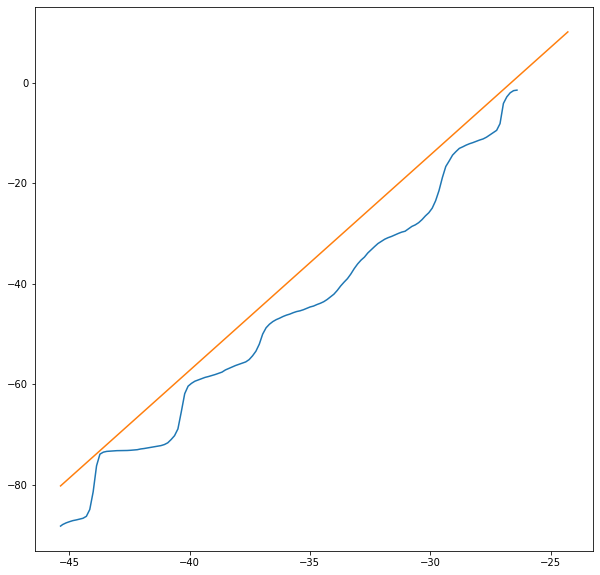

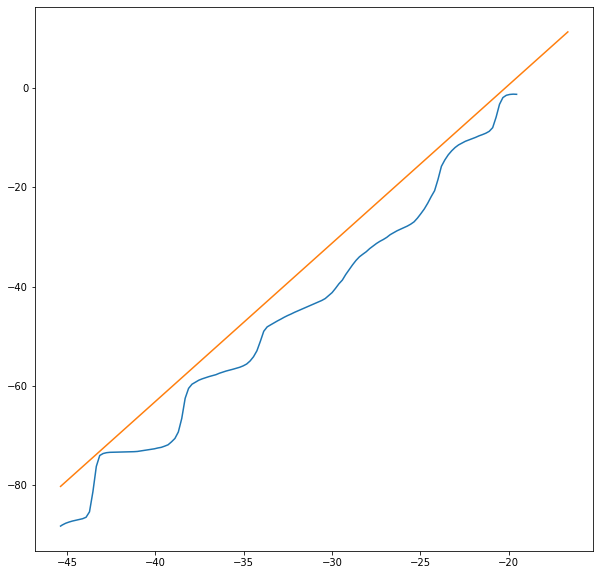

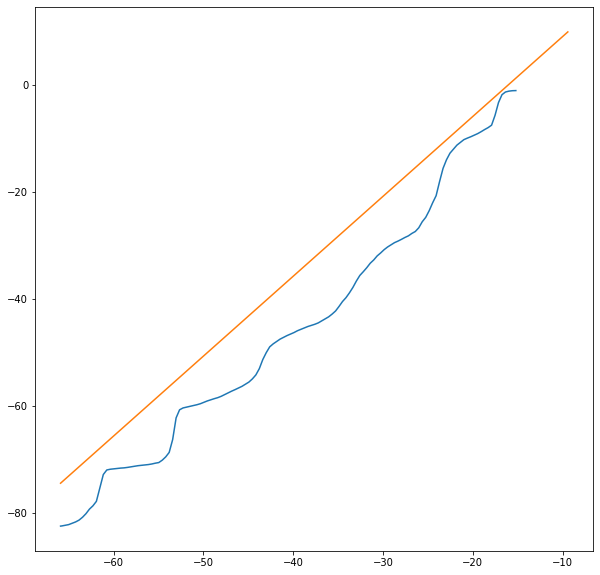

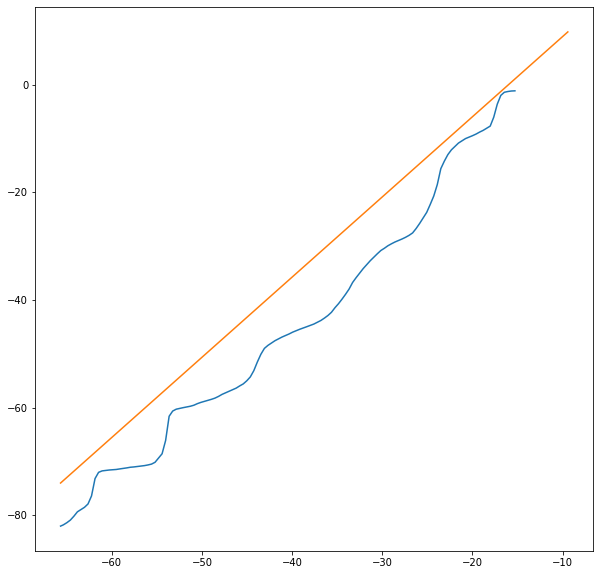

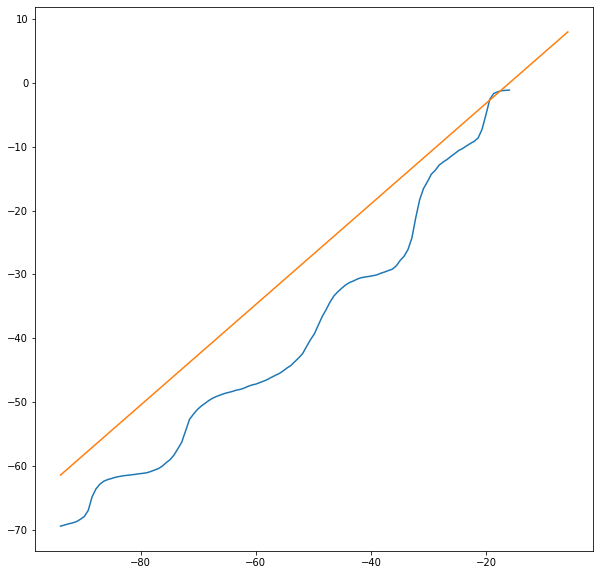

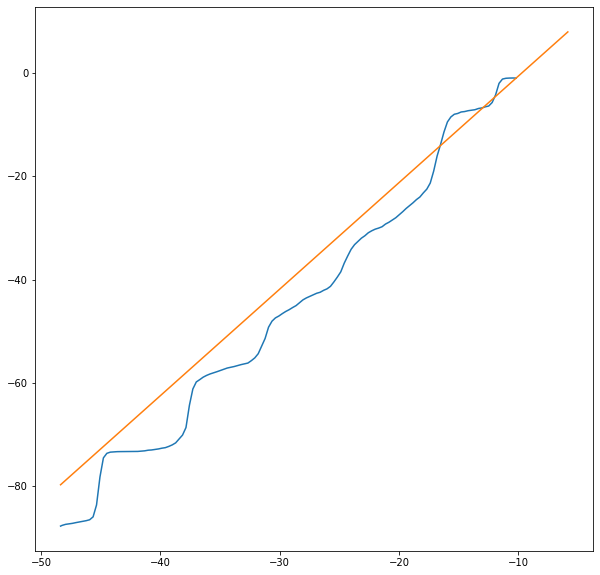

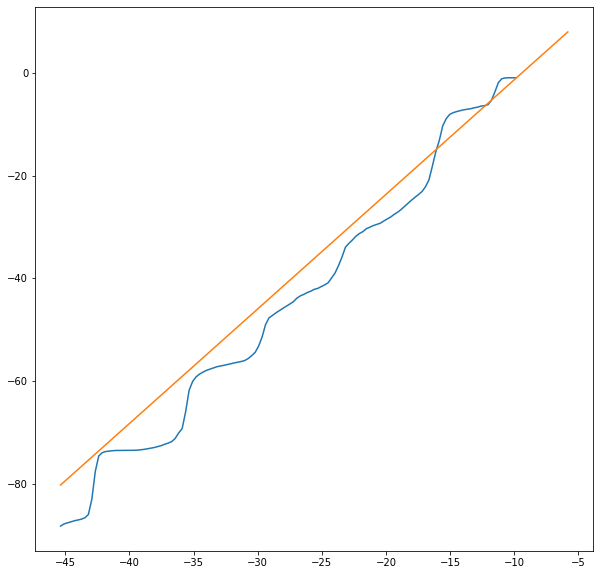

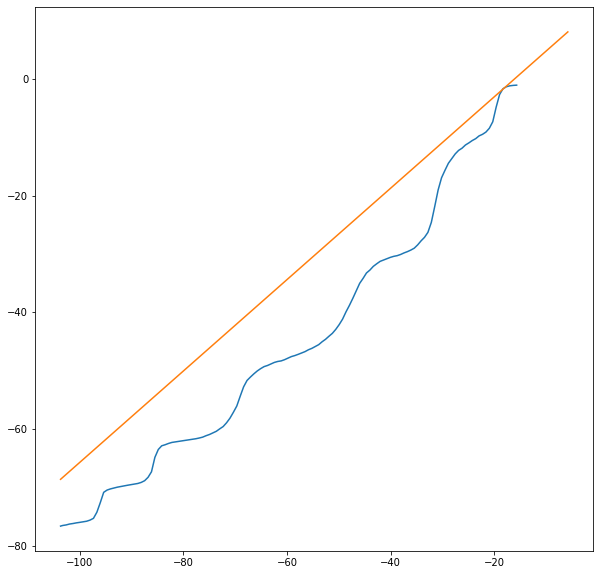

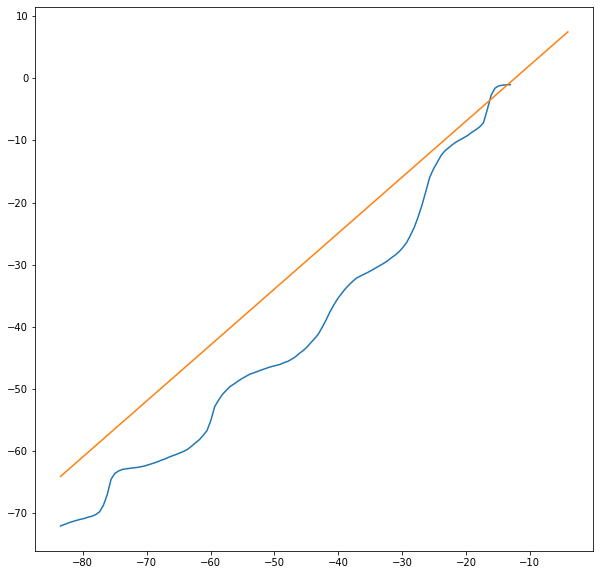

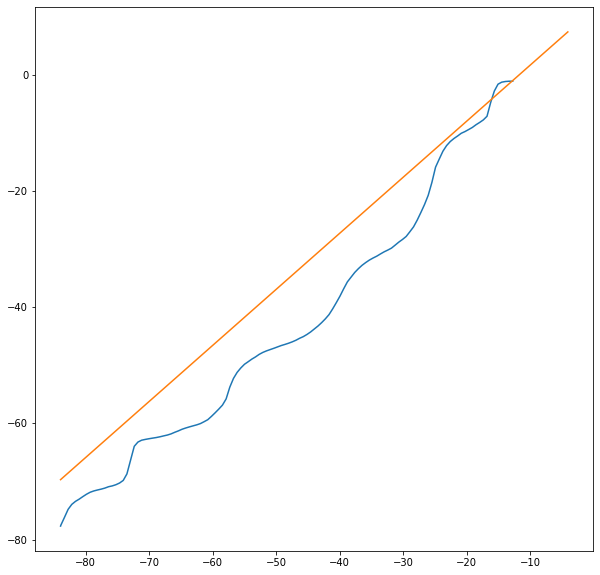

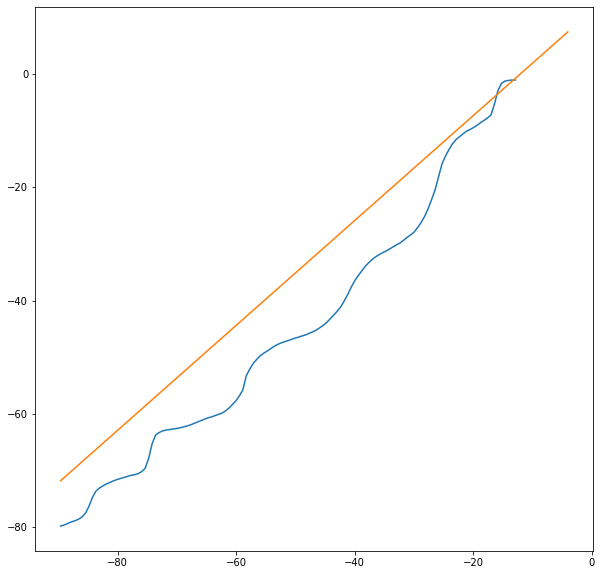

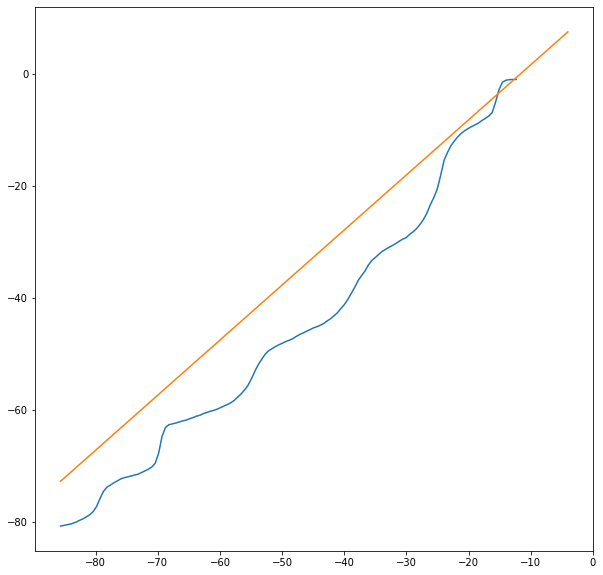

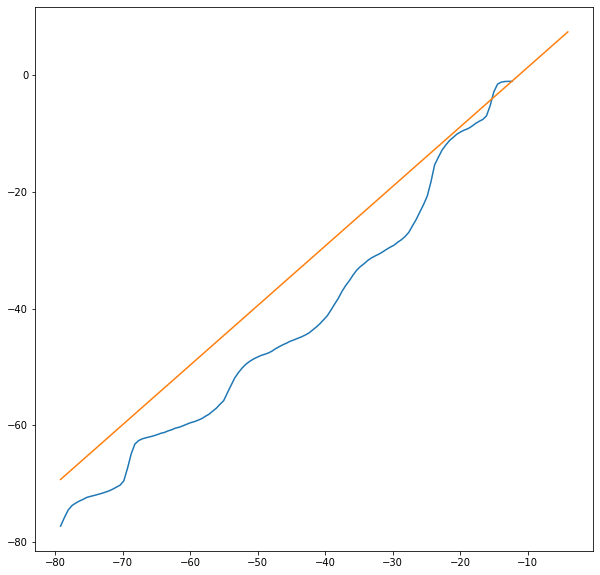

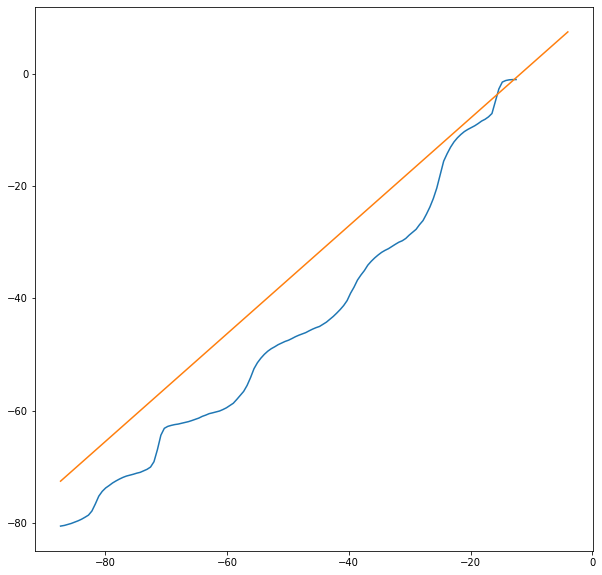

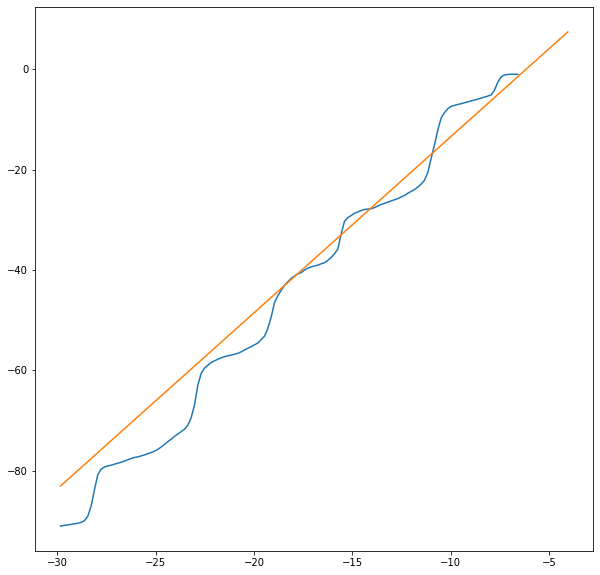

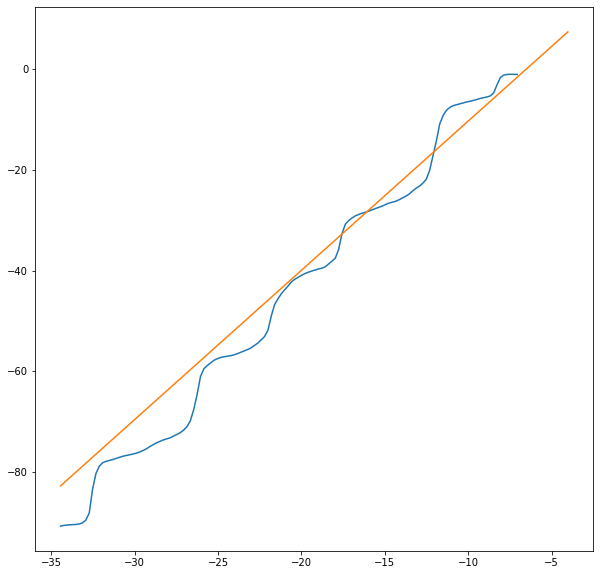

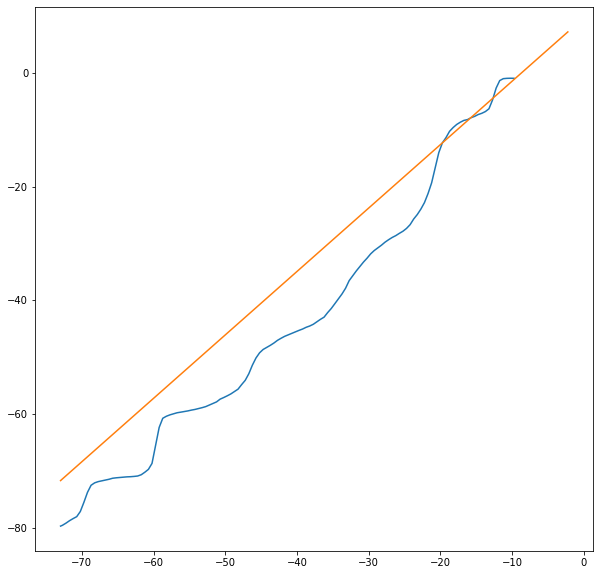

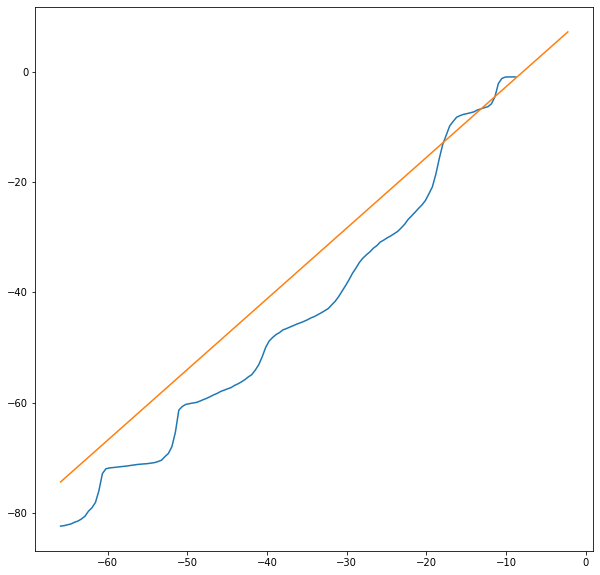

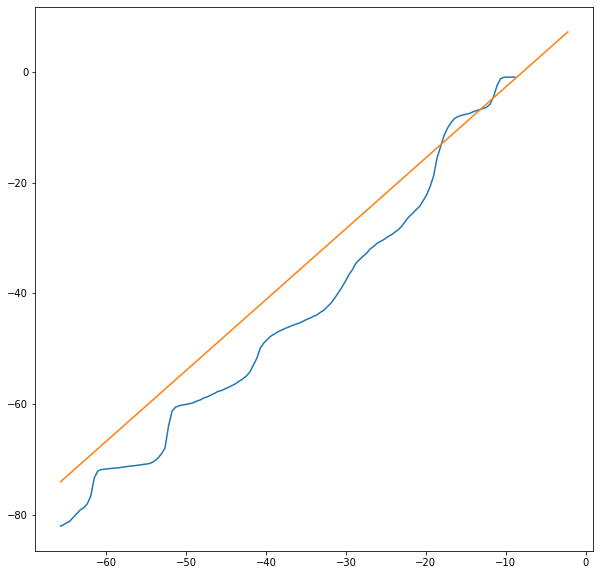

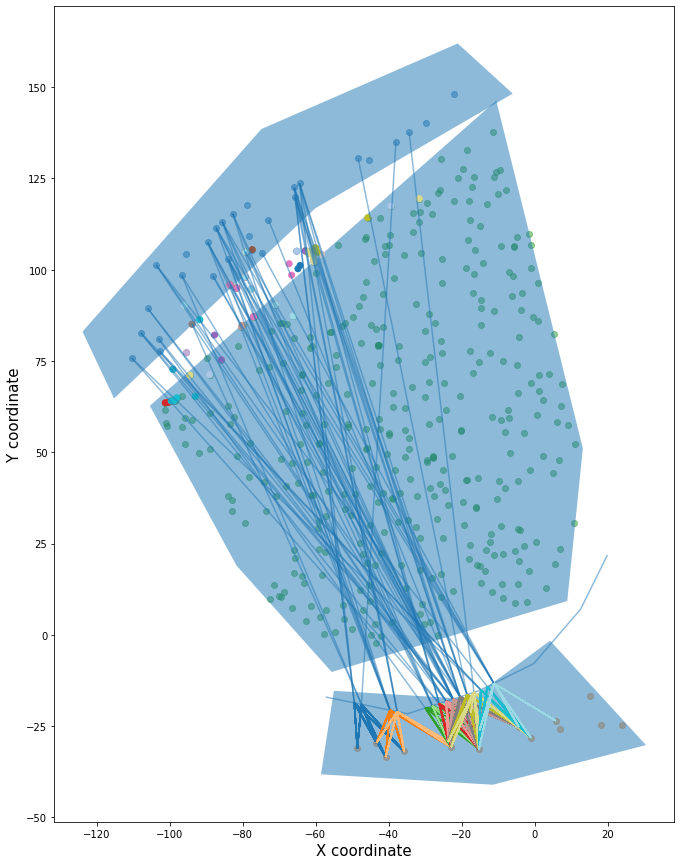

In [39]:
reload(geometry_operations)
reload(geometry_utilities)
reload(plotting)

possible_lines, slope_deviation, possible_anchor_triples, possible_support_trees = geometry_operations.generate_possible_lines(road_points, target_trees_gdf_filtered_diameter, anchor_trees_gdf_filtered_diameter, tree_gdf, slope_line, height_gdf)
print("we have n lines: ",len(possible_lines))

line_gdf = gpd.GeoDataFrame(geometry=possible_lines)

#add the length of each line
line_gdf["line_length"] = line_gdf.geometry.length
line_gdf["slope_deviation"] = slope_deviation
line_gdf["possible_anchor_triples"] = possible_anchor_triples
line_gdf["possible_support_trees"] = possible_support_trees

plotting.plot_gdf_with_anchors_and_supports([target_trees_gdf_filtered_diameter,anchor_trees_gdf_filtered_diameter, inner_forest_gdf, extra_geometry_gpd], line_gdf)

#### Optimization Setup

In [12]:
reload(geometry_operations)
reload(optimization_functions)

# Apply the Line Cost Function:
line_gdf["line_cost"] = [optimization_functions.line_cost_function(length, cost) for length,cost in zip(line_gdf["line_length"],line_gdf["slope_deviation"])]

# Create a matrix with the distance between every tree and line
cost_matrix = geometry_operations.compute_distances_facilities_clients(harvesteable_trees_gdf, line_gdf)

# sort the facility (=lines) and demand points (=trees)
facility_points_gdf = line_gdf.reset_index()
demand_points_gdf = harvesteable_trees_gdf.reset_index()

# set up the solver
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)
name = "model"

# create the nr of possible facilities and clients 
client_range = range(cost_matrix.shape[0])
facility_range = range(cost_matrix.shape[1])

# add facility cost
# with scaling factor
facility_scaling_factor = 150
facility_cost = line_gdf.line_cost.values*facility_scaling_factor

# and set the BHD as "weight" of the tree for now - substitute this via better computation
client_demand = optimization_functions.tree_cost_function(harvesteable_trees_gdf.BHD)

# create the aij cost matrix
weights = np.reshape(client_demand.values, (cost_matrix.shape[0], 1))
aij = cost_matrix * weights

#### SpOPT

Creating our custom problem with constraints

- Obj Func v4:
	- ```sum(lscp.aij[cli][fac] * cli_assgn_vars[cli][fac])```
		- minimize the overall distance between clients and the factory they are assigned too
	- ```sum(fac_vars[fac]*fac_cost[fac] for fac in facility_range])```
		- minimize the sum of factory costs

- Matrices:
	- Lineactiveindex = fac_vars = $[l1+l2...]$
	- linetreeactiveindex = cli_assgn_vars = $[[l1*cli1+l1*cli2...],[l2*cli1+l2*cli2+....]]$

	- fac_cost: the cost of each line
	- cli_demand: mocked variable as of now, can be changed to reflect profit of given tree

- Constraints:
	- Constraint 1:
		- Each client is only assigned to one factory: ```pulp.lpSum([cli_assgn_vars[cli][fac] for fac in facility_range]) == 1```

	- Constraint 2: 
		- Every factory that has a client assigned must be opened: ```lscp.problem += fac_vars[fac] - cli_assgn_vars[cli][fac] >= 0```



In [21]:
model_list = []
steps = 1

# iterate combinations of 0.1 steps for a MOO tradeoff
for i in range(steps):

    # init the model with name and the problem - this only gives it a name and tells it to minimize the obj function
    problem = pulp.LpProblem(name, pulp.LpMinimize)
    model = PMedian(name, problem, aij)

    # Add the facilities as fac_vars and facility_clients as cli_assgn_vars
    optimization_functions.add_facility_variables(model, facility_range)
    optimization_functions.add_facility_client_variables(model, facility_range, client_range)

    # Add the objective functions
    optimization_functions.add_moo_objective_function(model, facility_range, client_range, facility_cost, 5)

    # Assignment/demand constraint - each client should only be assigned to one factory
    optimization_functions.add_singular_assignment_constraint(model, facility_range, client_range)

    # Add opening/shipping constraint - each factory that has a client assigned to it should also be opened
    optimization_functions.add_facility_is_opened_constraint(model, facility_range, client_range)

    model = model.solve(solver)
    model_list.append(model)

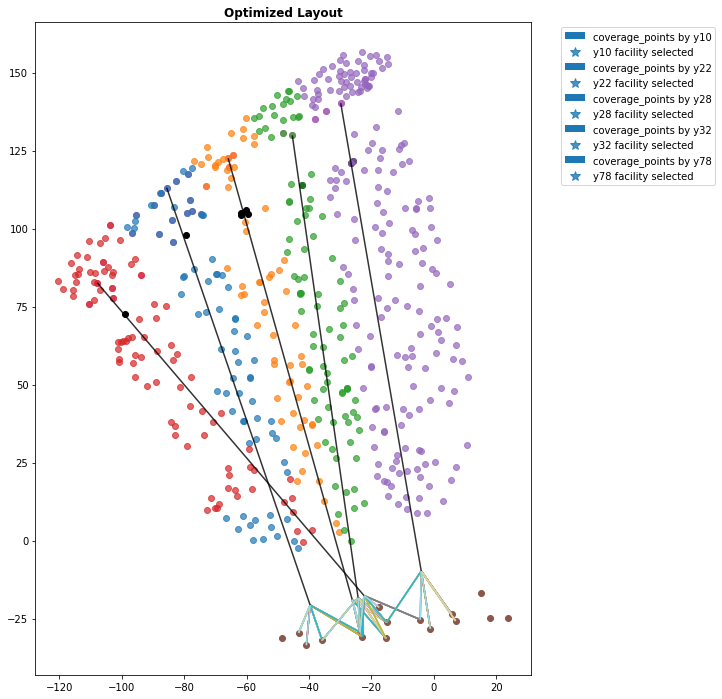

In [22]:
reload(plotting)
for i in range(steps):
    plotting.plot_p_median_results(model_list[i], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)

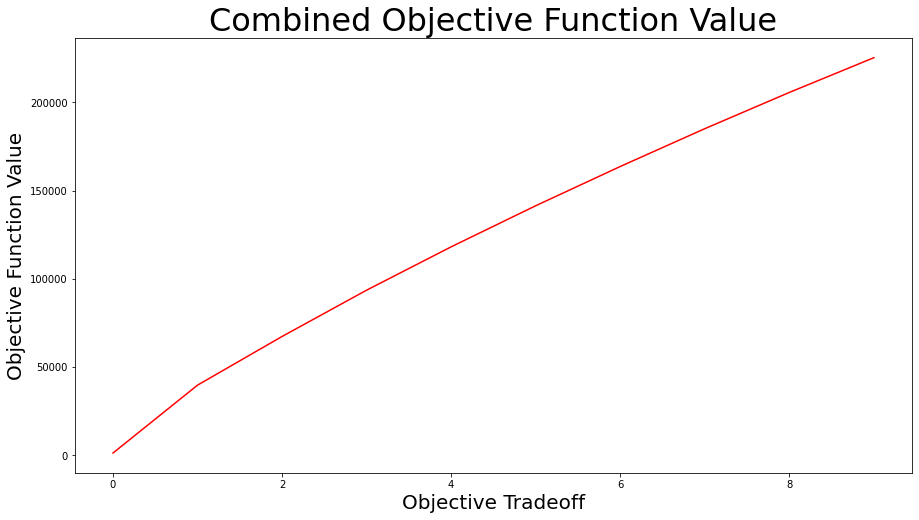

In [70]:
# visualize optimization outcome, using matplotlib.pyplot
plt.figure(figsize=(15,8))

obj_1_list = [i for i in range(steps)]

# Value of objective function
obj_2_list = [model_list[i].problem.objective.value() for i in range(steps)]

obj_difference = [obj_2_list[i+1]-obj_2_list[i] for i in range(steps-1)]
obj_difference.append(0)

plt.plot(obj_1_list,obj_2_list, color="red")

plt.xlabel("Objective Tradeoff",size=20)
plt.ylabel("Objective Function Value",size=20)
# -- add plot title
plt.title("Combined Objective Function Value",size=32)
# -- show plot
plt.show()

#### PyMOO Testing

In [82]:
import moo_optimization_functions

In [98]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

#import moo_optimization_functions
reload(moo_optimization_functions)

problem = moo_optimization_functions.SupportLinesProblem(cost_matrix, facility_cost)
termination = get_termination("n_gen", 5)

reload(optimization_functions)

client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]

algorithm = NSGA2(
    population=100,
    sampling=IntegerRandomSampling(),
    mutation=moo_optimization_functions.MyMutation(),
    repair=moo_optimization_functions.MyRepair(),
)

res = minimize(problem,
               algorithm,
               termination,
               verbose=True,
               return_least_infeasible=True,
               seed=2)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      7 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     10 |  0.000000E+00 |  0.000000E+00 |  0.4037399694 |         ideal
     3 |      300 |     15 |  0.000000E+00 |  0.000000E+00 |  0.1944669641 |         ideal
     4 |      400 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0404454660 |         ideal
     5 |      500 |     35 |  0.000000E+00 |  0.000000E+00 |  0.0352885290 |         ideal


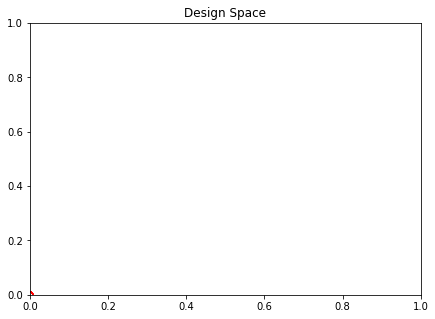

In [99]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

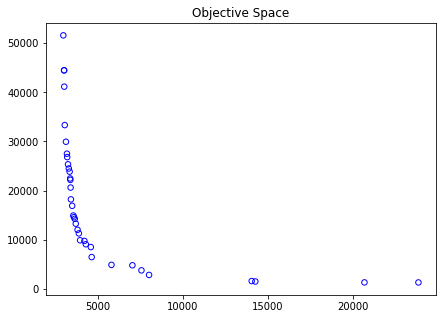

In [100]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

In [101]:
x_sol = X[-10]

# Debugging
variable_matrix = x_sol.reshape((len(demand_points_gdf)+1,len(line_gdf)))

cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1]

#fac_vars
print(cli_assgn_vars[1:5])
#print(np.sum(cli_assgn_vars, axis=1))
print(fac_vars)

[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0]]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0]


In [109]:
X.shape[0]

35

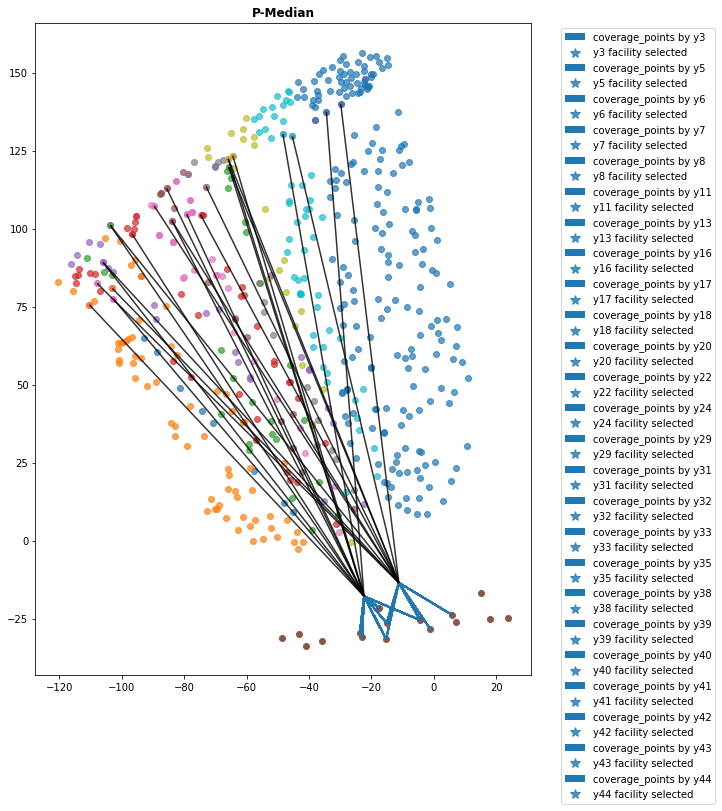

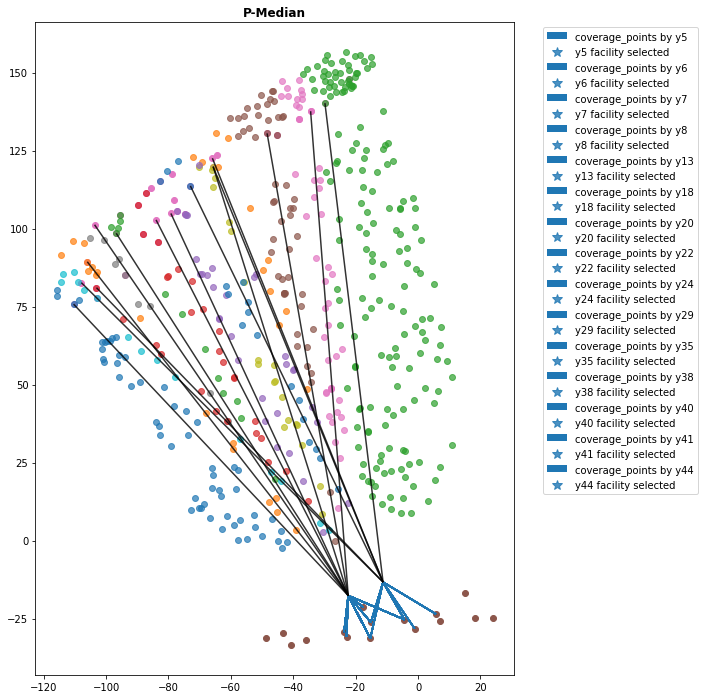

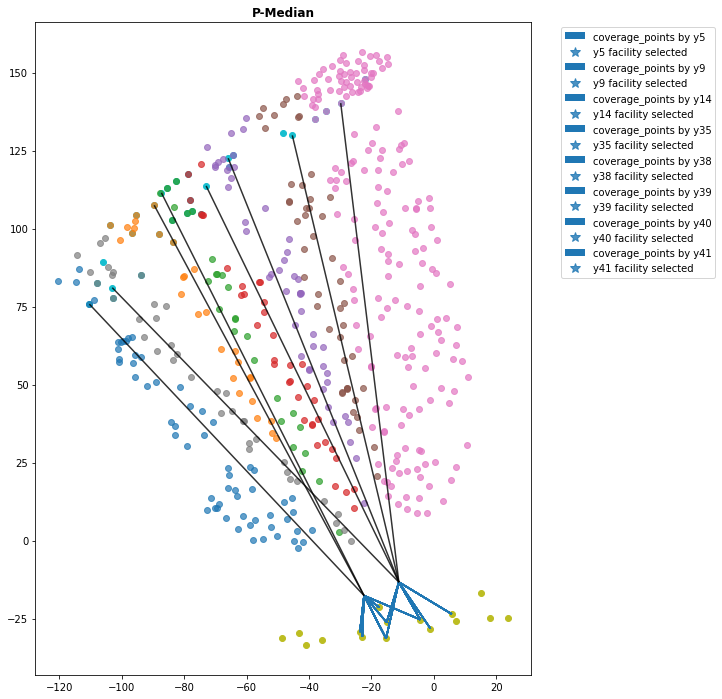

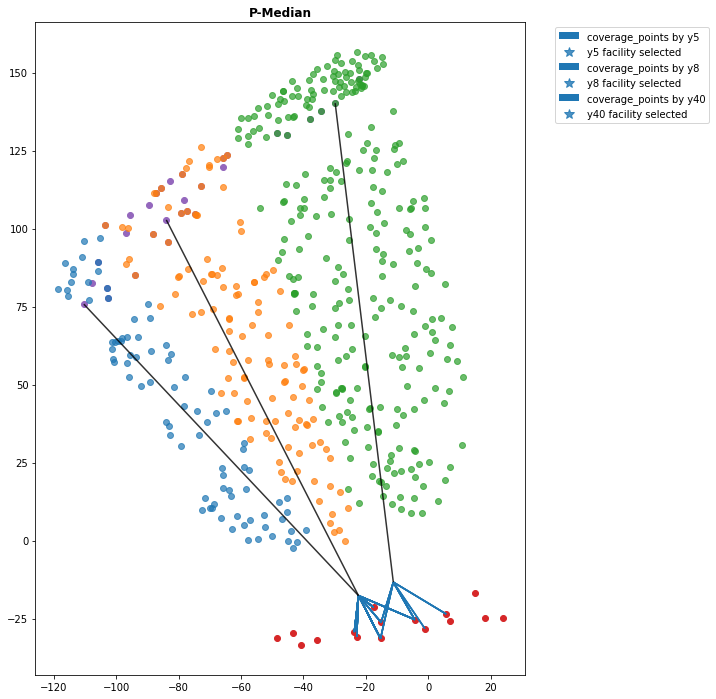

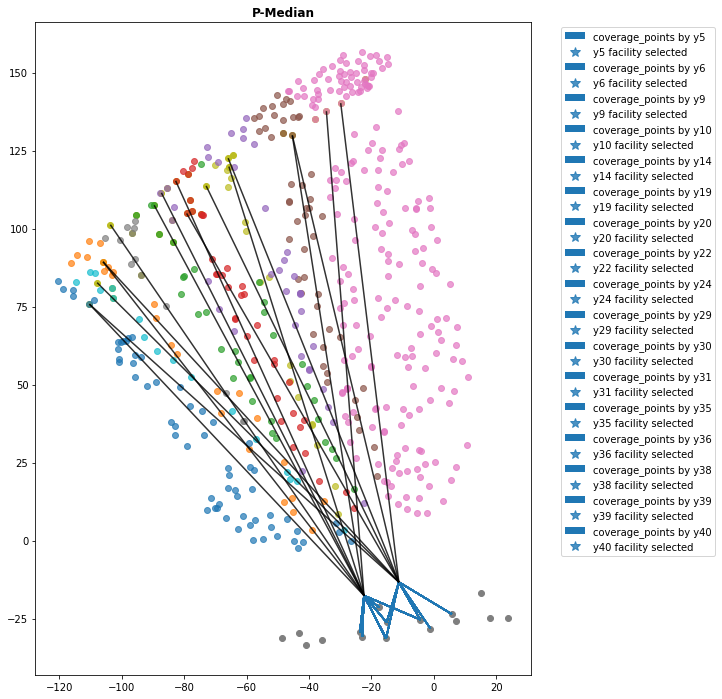

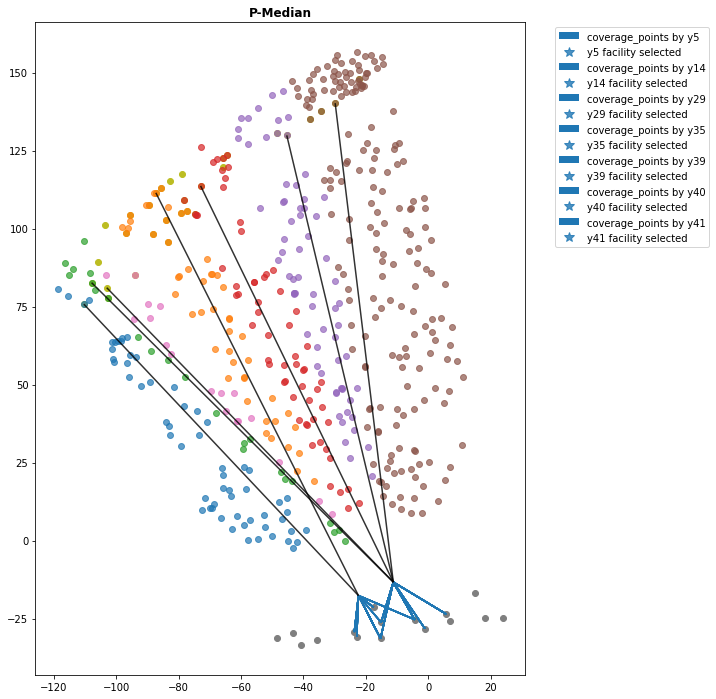

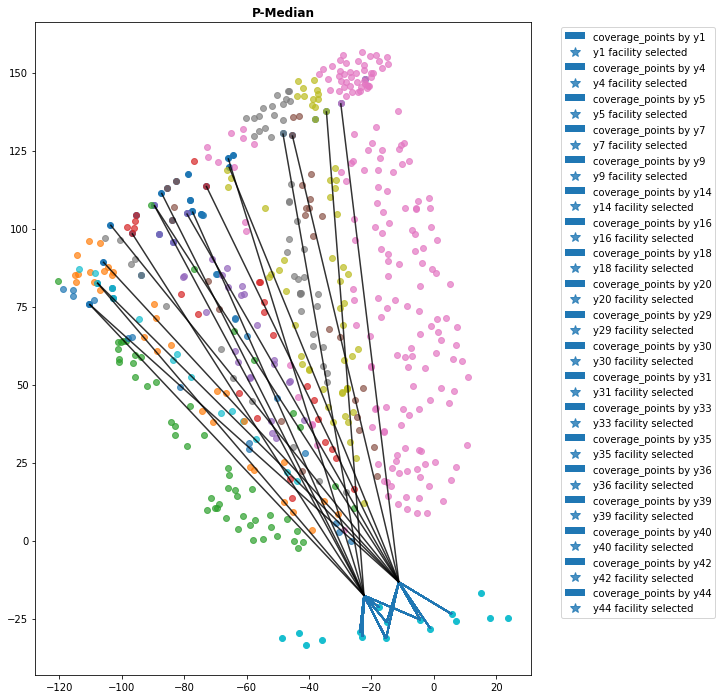

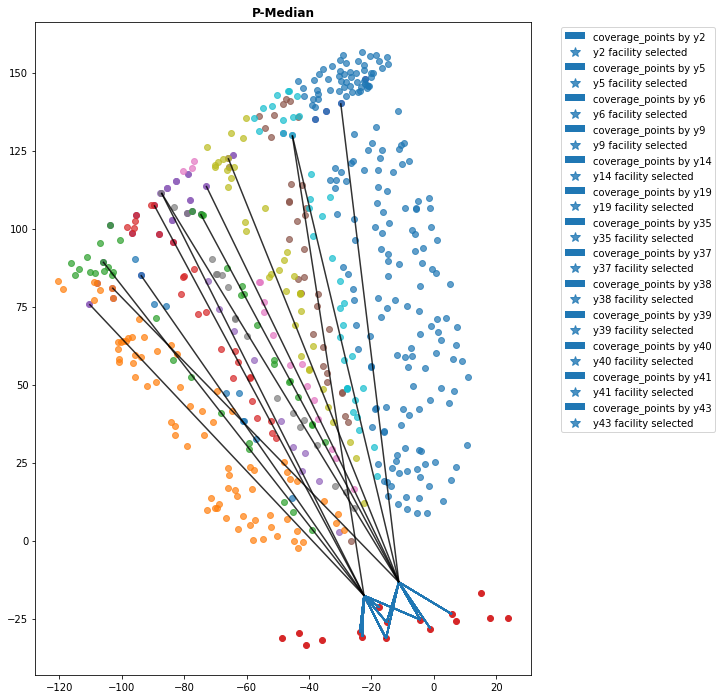

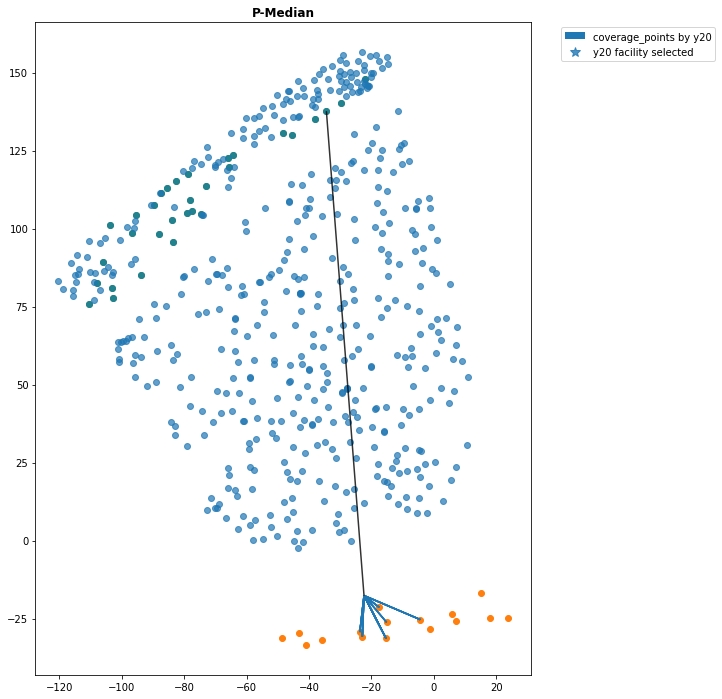

In [116]:
# Visualizations
client_range = cost_matrix.shape[0]
facility_range = cost_matrix.shape[1]
cli_assgn_vars = variable_matrix[:-1]
fac_vars = variable_matrix[-1:]

reload(plotting)

for x_sol in range(0,X.shape[0],4):
    plotting.plot_pymoo_results(X[x_sol], facility_points_gdf, demand_points_gdf, anchor_trees_gdf_filtered_diameter, target_trees_gdf_filtered_diameter, line_gdf)